In [82]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# The Dataset Recap Blog<a id="0"></a>

Here is a review of TIME SERIES and its concept

<div class="alert alert-danger" style="margin-top: 20px">
    
<a>https://alyxcoder-d840d.stackbit.app/blog/post-four/</a>

# Uploading Dataset and Indexing with TIME  <a id="0"></a>

    

In [84]:
import pandas as pd
# Import the data
df = pd.read_csv("nike_2020_04_13.csv")
df['Date'] = pd.to_datetime(df['Date'])
# Set the date as index 
df = df.set_index('Date')
# Select the proper time period for weekly aggregation
df = df['2020-04-12':'2022-01-14'].resample('W').sum()
df.head()

,Listing Price,Sale Price,Discount,Orders,Rating,Reviews
Date,,,,,,
2020-04-12,881,7495,8,5554,4,874
2020-04-19,3871,63465,57,33398,24,4302
2020-04-26,3506,83965,45,32686,27,3765
2020-05-03,11299,77067,62,34448,18,4334
2020-05-10,4215,84465,54,36595,26,4942


In [86]:
df.isnull().sum()

Listing Price    0
Sale Price       0
Discount         0
Orders           0
Rating           0
Reviews          0
dtype: int64

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 2020-04-12 to 2022-01-16
Freq: W-SUN
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Listing Price  93 non-null     int64
 1   Sale Price     93 non-null     int64
 2   Discount       93 non-null     int64
 3   Orders         93 non-null     int64
 4   Rating         93 non-null     int64
 5   Reviews        93 non-null     int64
dtypes: int64(6)
memory usage: 5.1 KB


In [88]:
df = df.astype({'Listing Price':'float', 'Sale Price':'float', 'Discount':'float', 'Orders':'float', 'Reviews':'float' })
print(df.dtypes)

Listing Price    float64
Sale Price       float64
Discount         float64
Orders           float64
Rating             int64
Reviews          float64
dtype: object


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93 entries, 2020-04-12 to 2022-01-16
Freq: W-SUN
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Listing Price  93 non-null     float64
 1   Sale Price     93 non-null     float64
 2   Discount       93 non-null     float64
 3   Orders         93 non-null     float64
 4   Rating         93 non-null     int64  
 5   Reviews        93 non-null     float64
dtypes: float64(5), int64(1)
memory usage: 5.1 KB


In [91]:
df.tail()

,Listing Price,Sale Price,Discount,Orders,Rating,Reviews
Date,,,,,,
2021-12-19,3166.00000000,63569.00000000,62.00000000,20771.00000000,20,3200.00000000
2021-12-26,4437.00000000,64271.00000000,56.00000000,33956.00000000,25,4220.00000000
2022-01-02,3365.00000000,60023.00000000,49.00000000,39378.00000000,14,3662.00000000
2022-01-09,2610.00000000,82519.00000000,53.00000000,26696.00000000,27,5193.00000000
2022-01-16,2648.00000000,45533.00000000,39.00000000,27763.00000000,11,1471.00000000


# DATA VISULIZATION  <a id="0"></a>

    

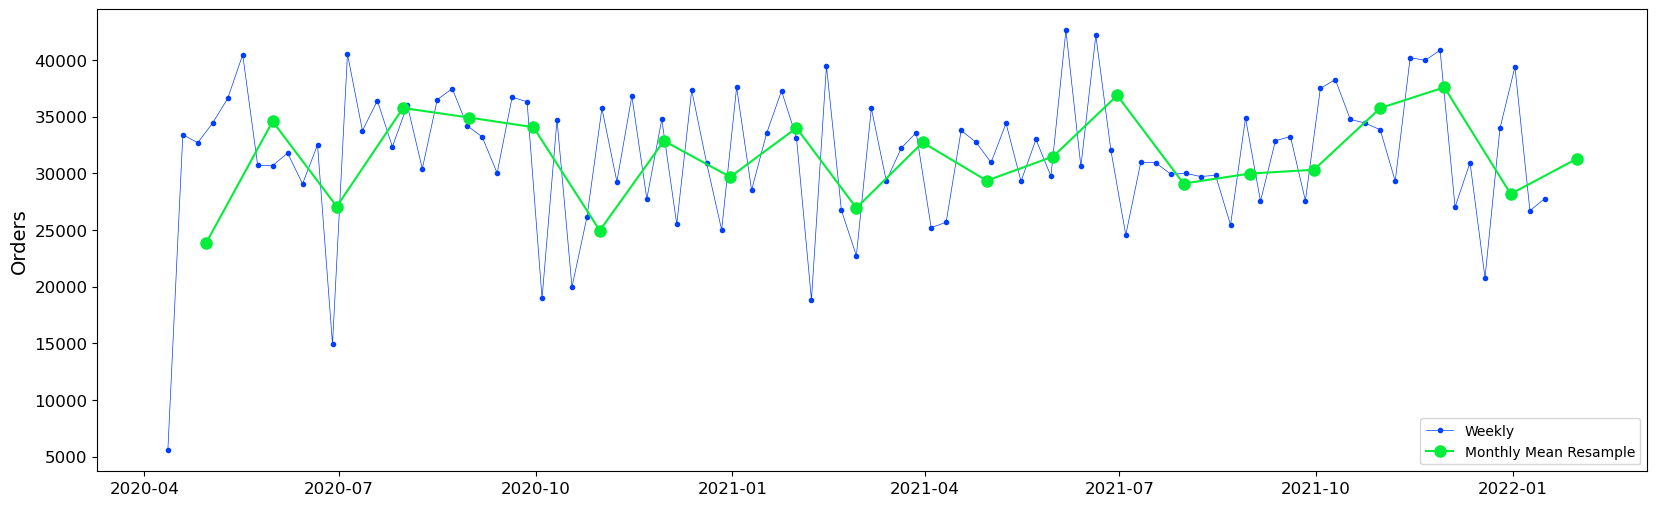

In [92]:
import warnings
import matplotlib.pyplot as plt
y = df['Orders']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

# DECOMPOSING THE DATA  <a id="0"></a>

    

In [93]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq', period=1)
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

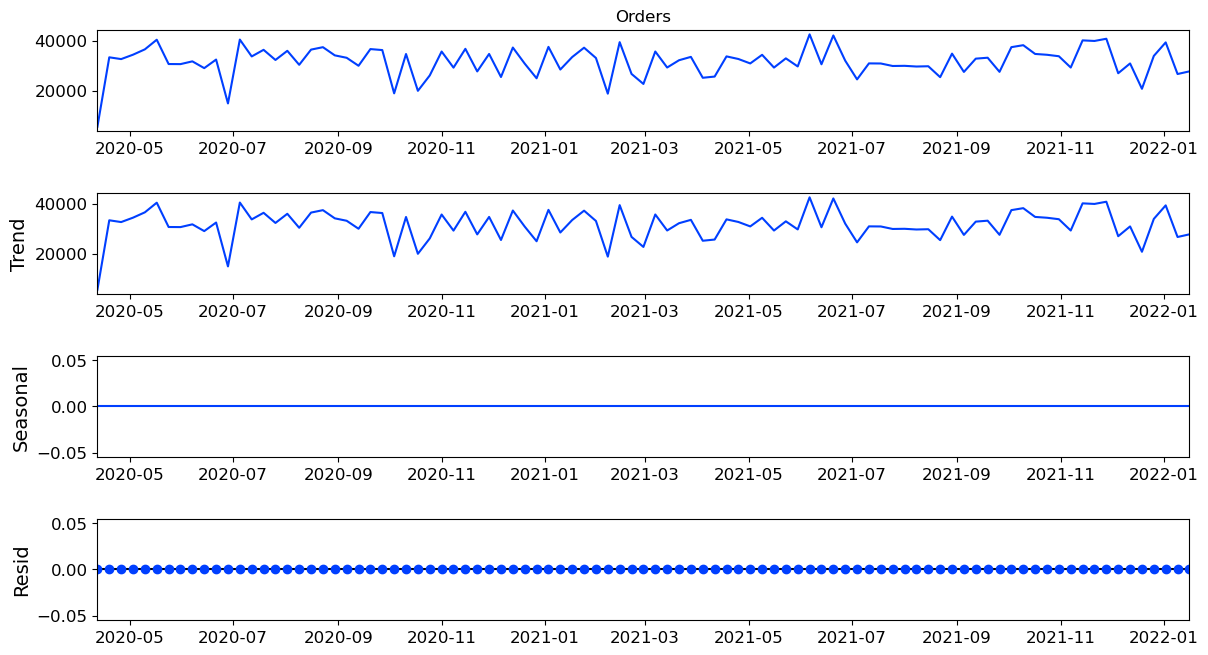

In [94]:
seasonal_decompose(y)

# CHECK STATIONARITY  <a id="0"></a>
A stationary process' distribution does not change over time. An intuitive example: you flip a coin. 50% heads, regardless of whether you flip it today or tomorrow or next year. A more complex example: by the efficient market hypothesis, excess stock returns should always fluctuate around zero

Read <a>https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788</a>

In [95]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    

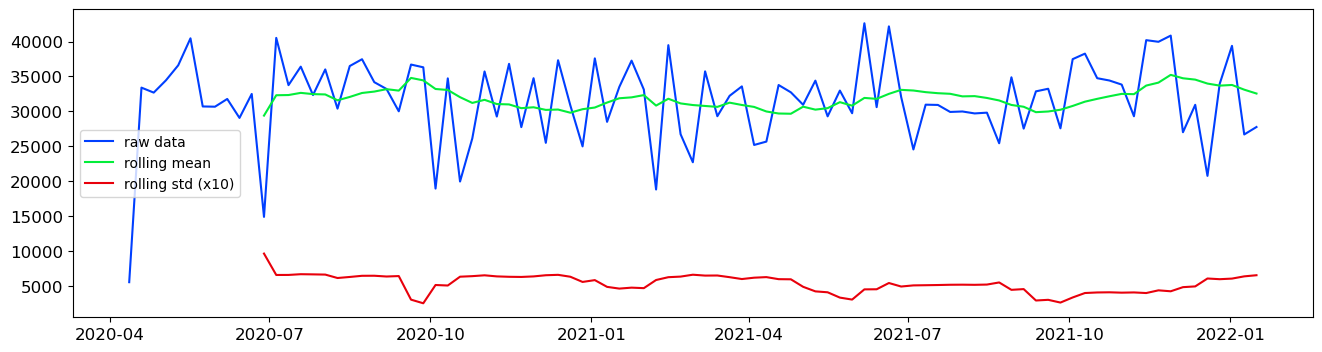

In [96]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

# Augmented Dickey-Fuller Test  <a id="0"></a>
Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series

Read <a>https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/</a>

In [97]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [98]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -3.853
P-value = 0.002
Critical values :
	1%: -3.5097356063504983 - The data is  stationary with 99% confidence
	5%: -2.8961947486260944 - The data is  stationary with 95% confidence
	10%: -2.5852576124567475 - The data is  stationary with 90% confidence


# DETRENDING  <a id="0"></a>
Detrending is removing a trend from a time series; a trend usually refers to a change in the mean over time. When you detrend data, you remove an aspect from the data that you think is causing some kind of distortion. For example, you might detrend data that shows an overall increase, in order to see subtrends

 > Is the de-trended data stationary ?
Test statistic = -4.164
P-value = 0.001
Critical values :
	1%: -3.526004646825607 - The data is  stationary with 99% confidence
	5%: -2.9032002348069774 - The data is  stationary with 95% confidence
	10%: -2.5889948363419957 - The data is  stationary with 90% confidence


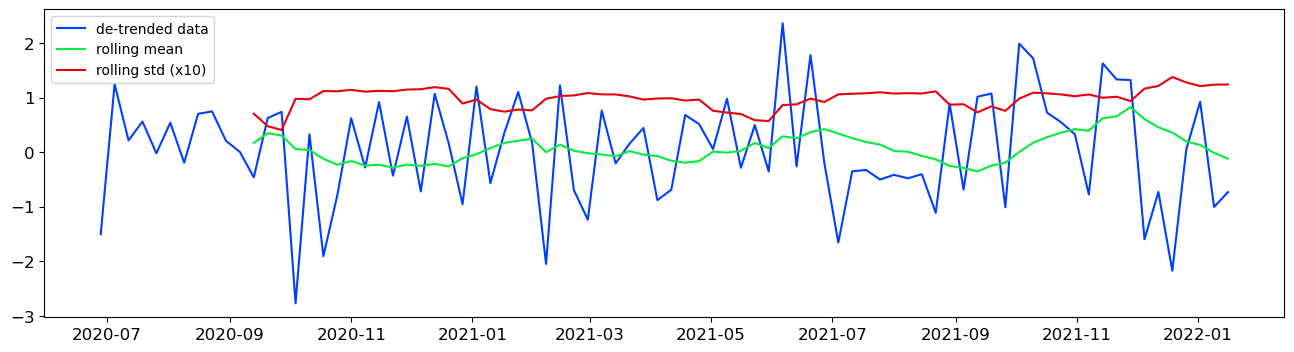

In [99]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

# DIFFERENCING  <a id="0"></a>
Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality. As well as looking at the time plot of the data, the ACF plot is also useful for identifying non-stationary time series.

 > Is the 12 lag differenced data stationary ?
Test statistic = -6.129
P-value = 0.000
Critical values :
	1%: -3.530398990560757 - The data is  stationary with 99% confidence
	5%: -2.9050874099328317 - The data is  stationary with 95% confidence
	10%: -2.5900010121107266 - The data is  stationary with 90% confidence


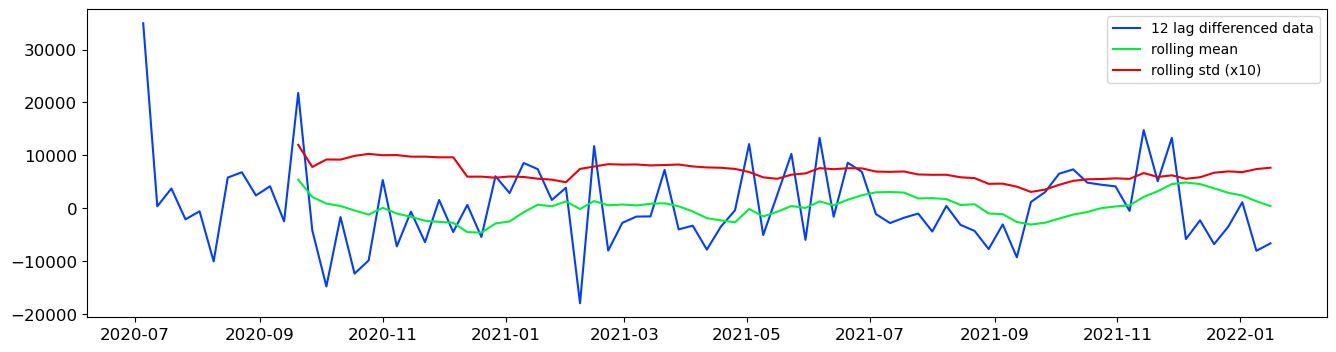

In [100]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

# DETRENDING + DIFFERENCING  <a id="0"></a>
Simplest method to detrend a time series is by differencing. Specifically, a new series is constructed where the value at the current time step is calculated as the difference between the original observation and the observation at the previous time step

 > Is the 30 lag differenced de-trended data stationary ?
Test statistic = -3.455
P-value = 0.009
Critical values :
	1%: -3.5925042342183704 - The data is not stationary with 99% confidence
	5%: -2.931549768951162 - The data is  stationary with 95% confidence
	10%: -2.60406594375338 - The data is  stationary with 90% confidence


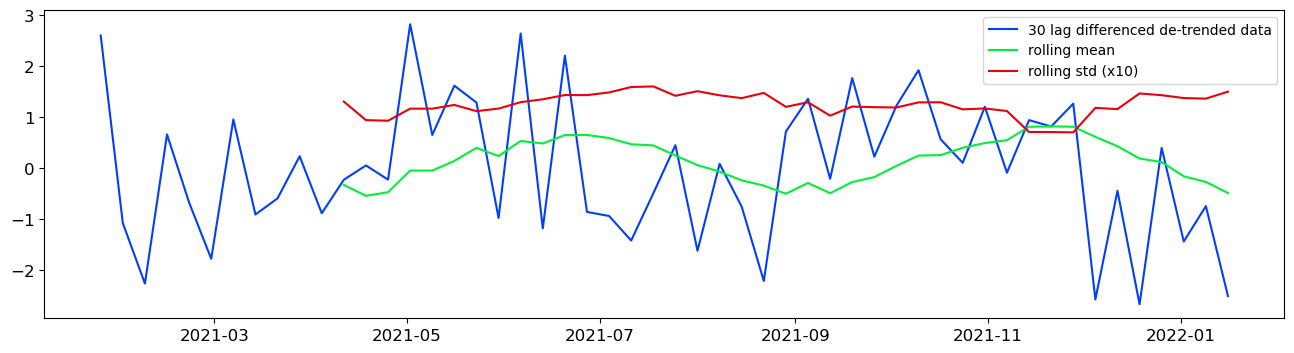

In [135]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(30)

test_stationarity(y_12lag_detrend,'30 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'30 lag differenced de-trended data')


# TRAIN THE DATA:  Y_TO_TRAIN, Y_T0_TEST, AND THE LENGTH OF PREDICT UNITS  <a id="0"></a>

In [136]:
y_to_train = y[:'2021-05-14'] # dataset to train
y_to_val = y['2021-06-02':] # last X months for test  
predict_date = len(y) - len(y[:'2021-06-02']) # the number of data points for the test set

# DIFFERENT TIME SERIES PREDICTION MODELS <a id="0"></a>
<H3>SIMPLE EXPONENTIAL SMOOTHING</H3>

In [137]:
import numpy as np
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()
    

The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 5418.05
The Root Mean Squared Error of our forecasts with auto optimization is 5297.3


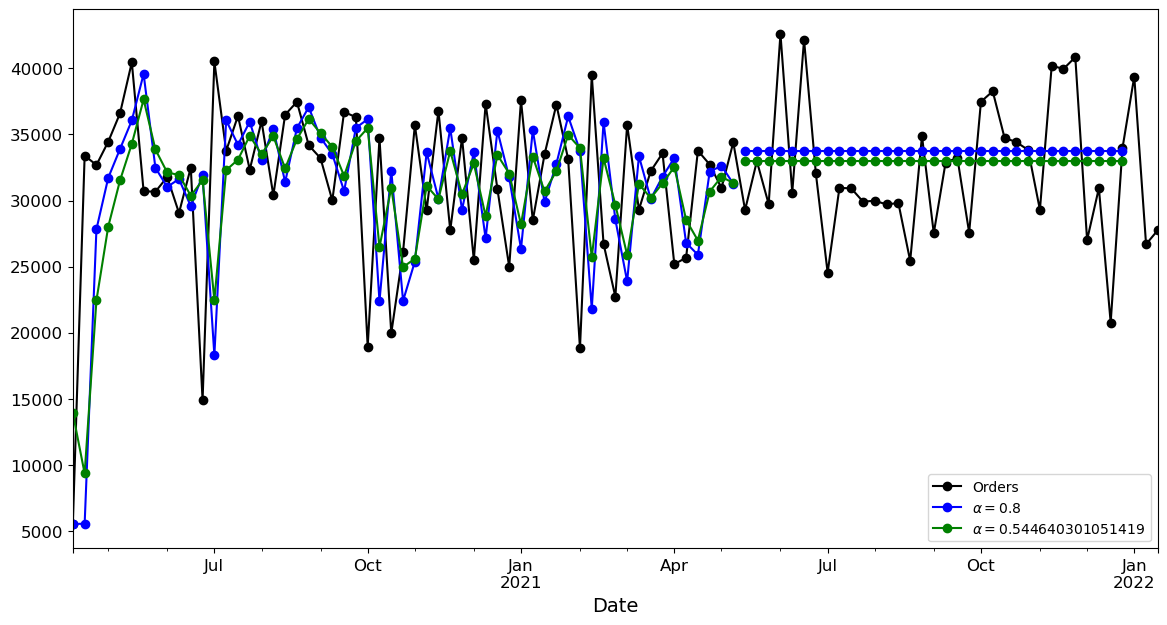

In [138]:
ses(y, y_to_train,y_to_val,0.8,predict_date)

# HOLT <a id="0"></a>

In [139]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()

The Root Mean Squared Error of Holts Linear trend 26471.39
The Root Mean Squared Error of Holts Exponential trend 49520.81


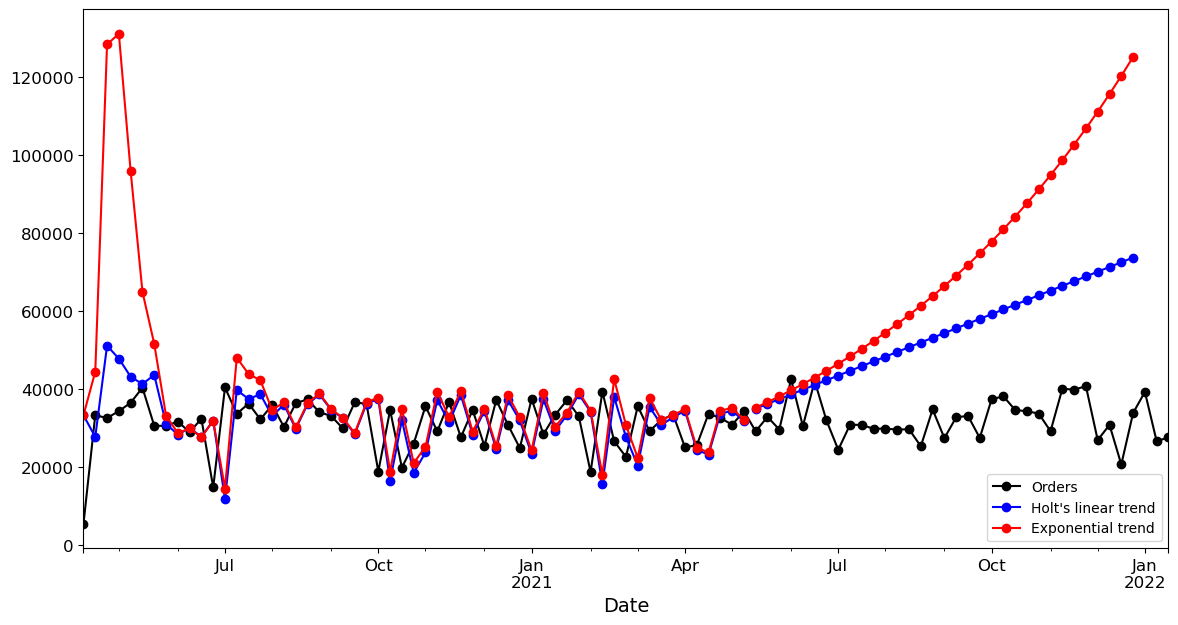

In [140]:
holt(y, y_to_train,y_to_val,0.8,0.5,predict_date)